# 5.2 pretrain or not

In [20]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def get_scaler_history(log_dir, tag):
    # 加载日志文件
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # 获取所有tags（包括scalars, images等）
    tags = event_acc.Tags()

    # 获取某个特定标量数据，例如训练损失 'train/loss'

    if tag not in tags['scalars']:
        print(f'tag must choose from {tags["scalars"]}')
        raise ValueError

    loss_data = event_acc.Scalars(tag)

    # 提取步数和对应的损失值
    steps = [x.step for x in loss_data]
    values = [x.value for x in loss_data]
    return steps, values


In [25]:
# 获取数据
log_dir1 = 'experiments/1009/1009_eqfdbp_trainD_step5_ntaps201_dtaps401_pretrain1_train1/logs/tensorboard'  # two stage training
log_dir2 = 'experiments/1009/1009_eqfdbp_trainD_step5_ntaps201_dtaps401_pretrain0_train1/logs/tensorboard'  # one stage training
tag = 'Metric/Qsq'

# 假设 get_scaler_history 是你用来读取 tensorboard 日志数据的函数
steps, value1 = get_scaler_history(log_dir1, tag)
_, value2 = get_scaler_history(log_dir2, tag)


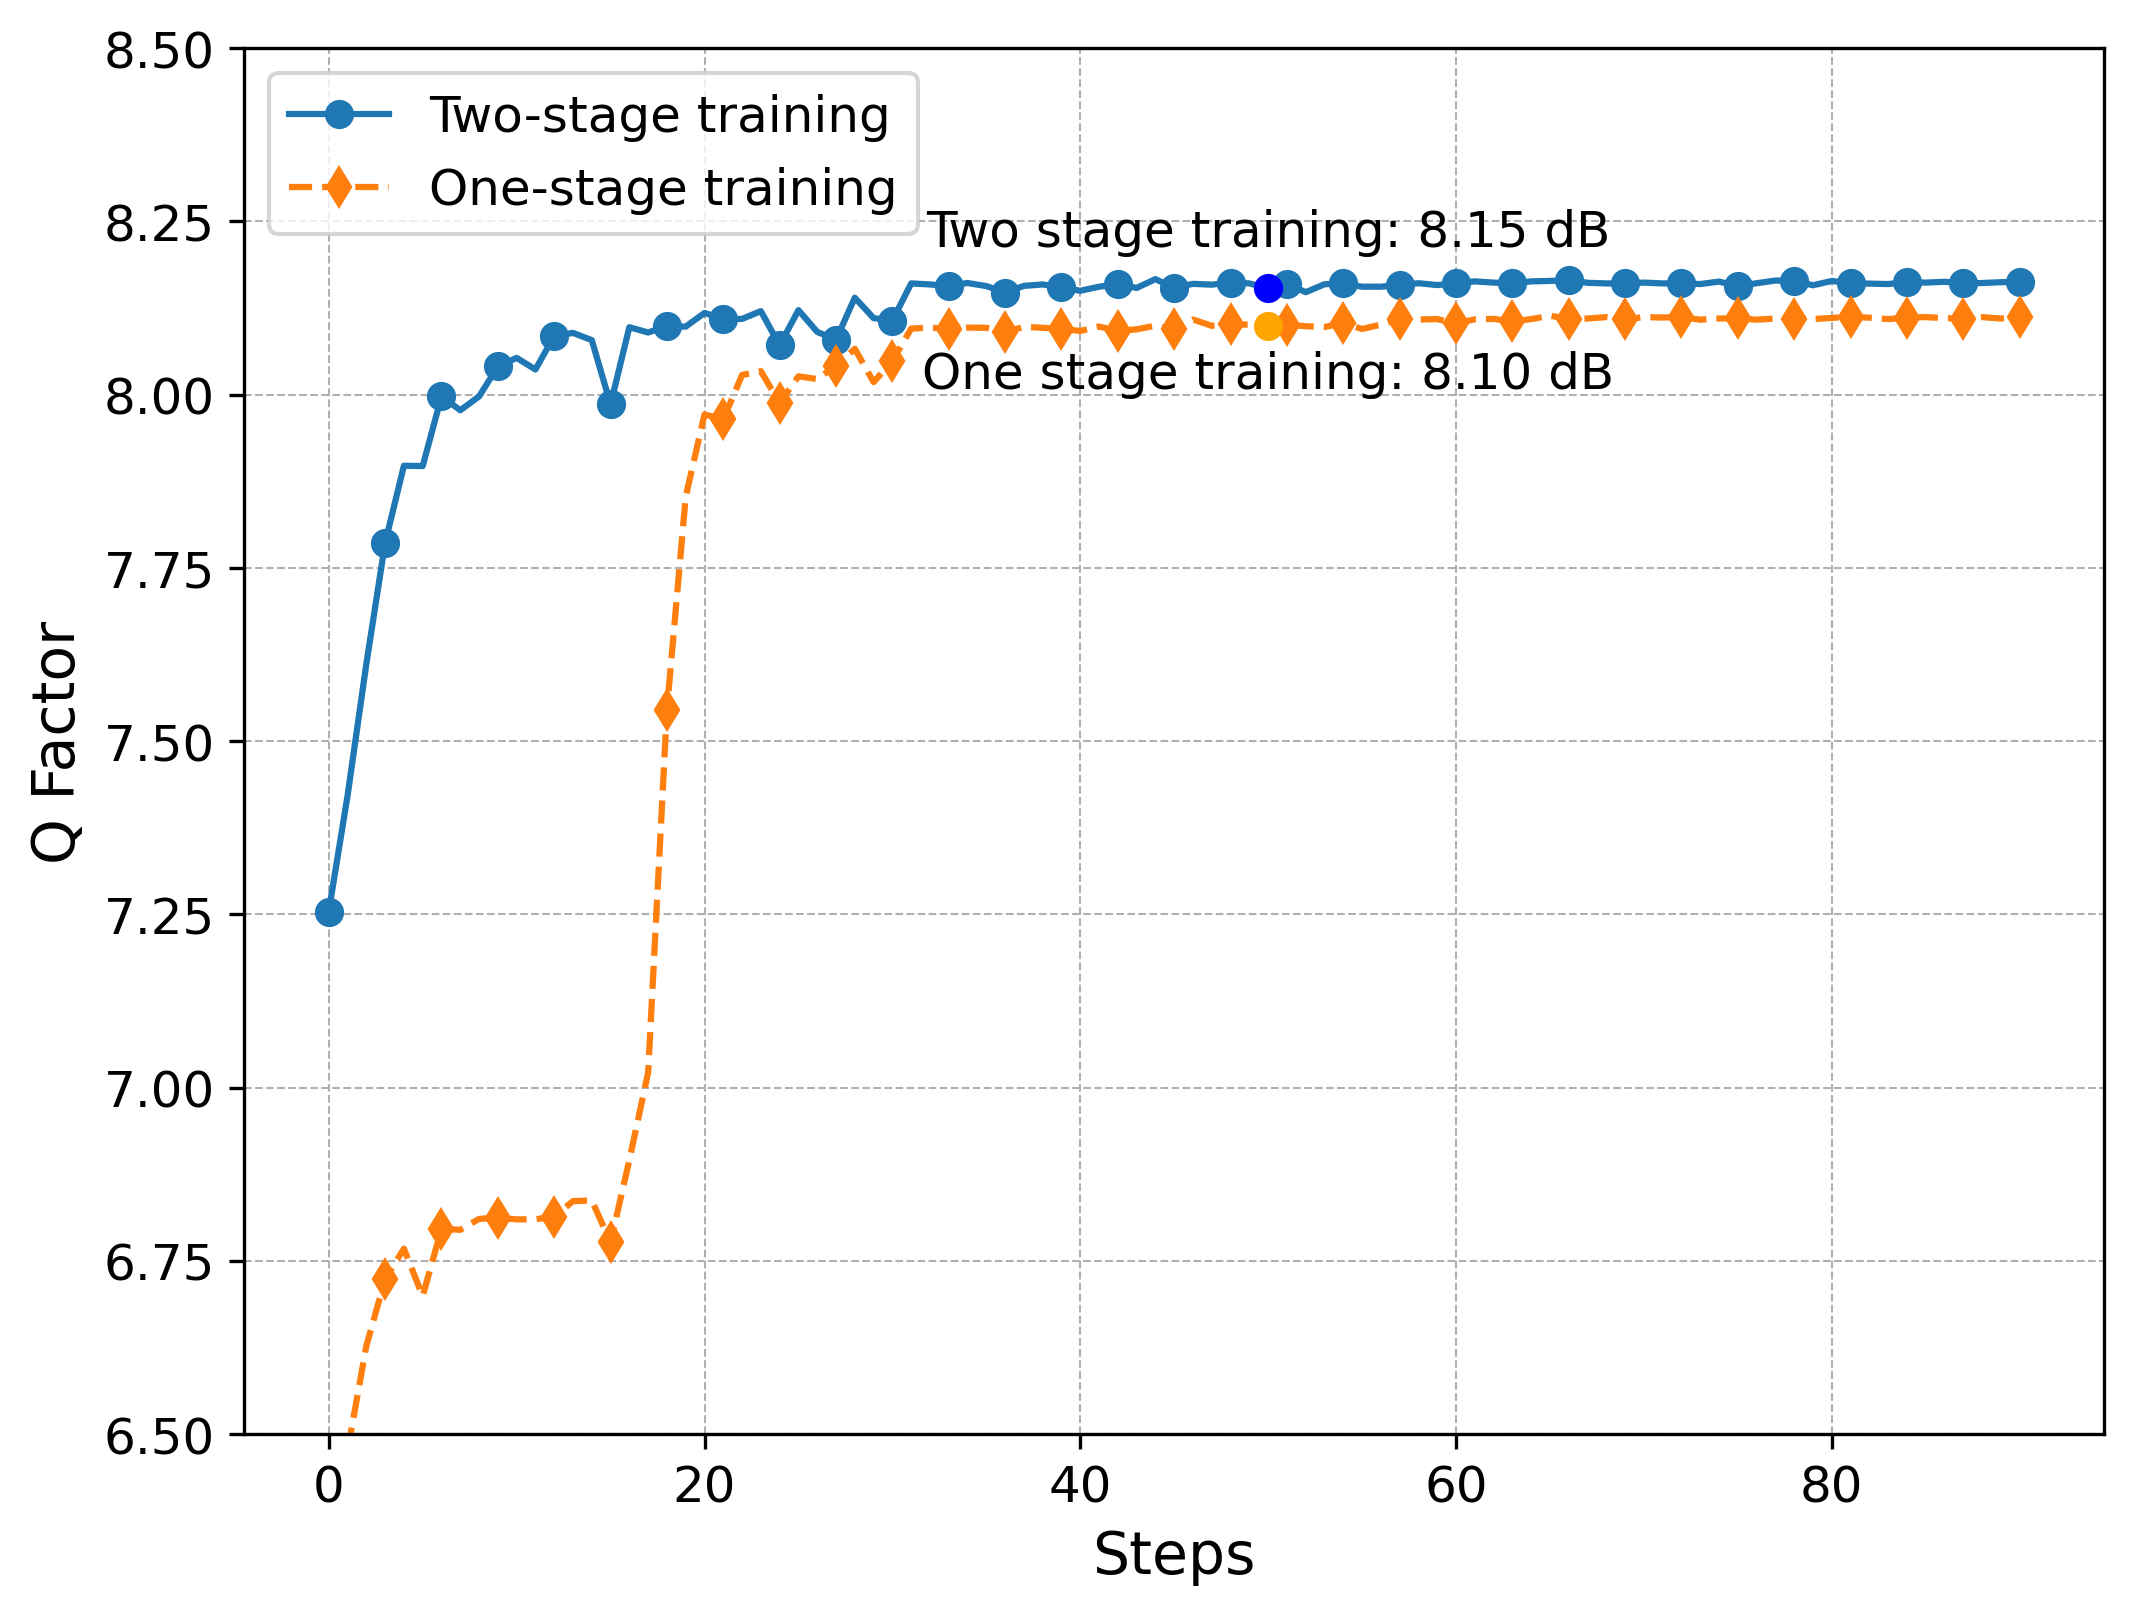

In [54]:
# 设置图表的大小和分辨率
plt.figure(figsize=(8, 6), dpi=300)

# 绘制两条曲线，并添加线型、颜色和标记
rate = 1
plt.plot(steps[::rate], value1[::rate], label='Two-stage training', linestyle='-', marker='o', markersize=6, linewidth=1.5, markevery=3)
plt.plot(steps[::rate], value2[::rate], label='One-stage training', linestyle='--', marker='d',markersize=6, linewidth=1.5, markevery=3)

# 设置坐标轴标签
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Q Factor', fontsize=14)

# 设置坐标轴刻度大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 添加网格，使用轻微的线条以辅助阅读
plt.ylim(6.5, 8.5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 设置图例并放置在右上角
plt.legend(fontsize=12, loc='best')

# 去掉标题
# plt.title('Training Loss over Time')

# text 
# 查找第50个epoch的索引
epoch_50_index = steps.index(50)

# 获取第50个epoch的值
epoch_50_value1 = value1[epoch_50_index]
epoch_50_value2 = value2[epoch_50_index]

# 在第50个epoch位置添加标记和注释
plt.scatter(50, epoch_50_value1, color='blue', zorder=5)
plt.scatter(50, epoch_50_value2, color='orange', zorder=5)

# 在图中标记第50个epoch的值并展示
plt.annotate(f'Two stage training: {epoch_50_value1:.2f} dB', (50, epoch_50_value1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
plt.annotate(f'One stage training: {epoch_50_value2:.2f} dB', (50, epoch_50_value2), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=12)

# 展示图表

plt.savefig('fig/5_2.png')

# 5.3 Post-processing Compensation

experiments/80G_3ch_frepbc_M41_rho1_ol40_strides161 rmps: 5116.890966209366
experiments/80G_3ch_frepbc_M41_rho1_ol40_strides161 Best Q afctor:  8.523959290756387
experiments/0909_freampbc_v1 rmps: 2951.0355781528983
experiments/0909_freampbc_v1 Best Q afctor:  8.516438708168499


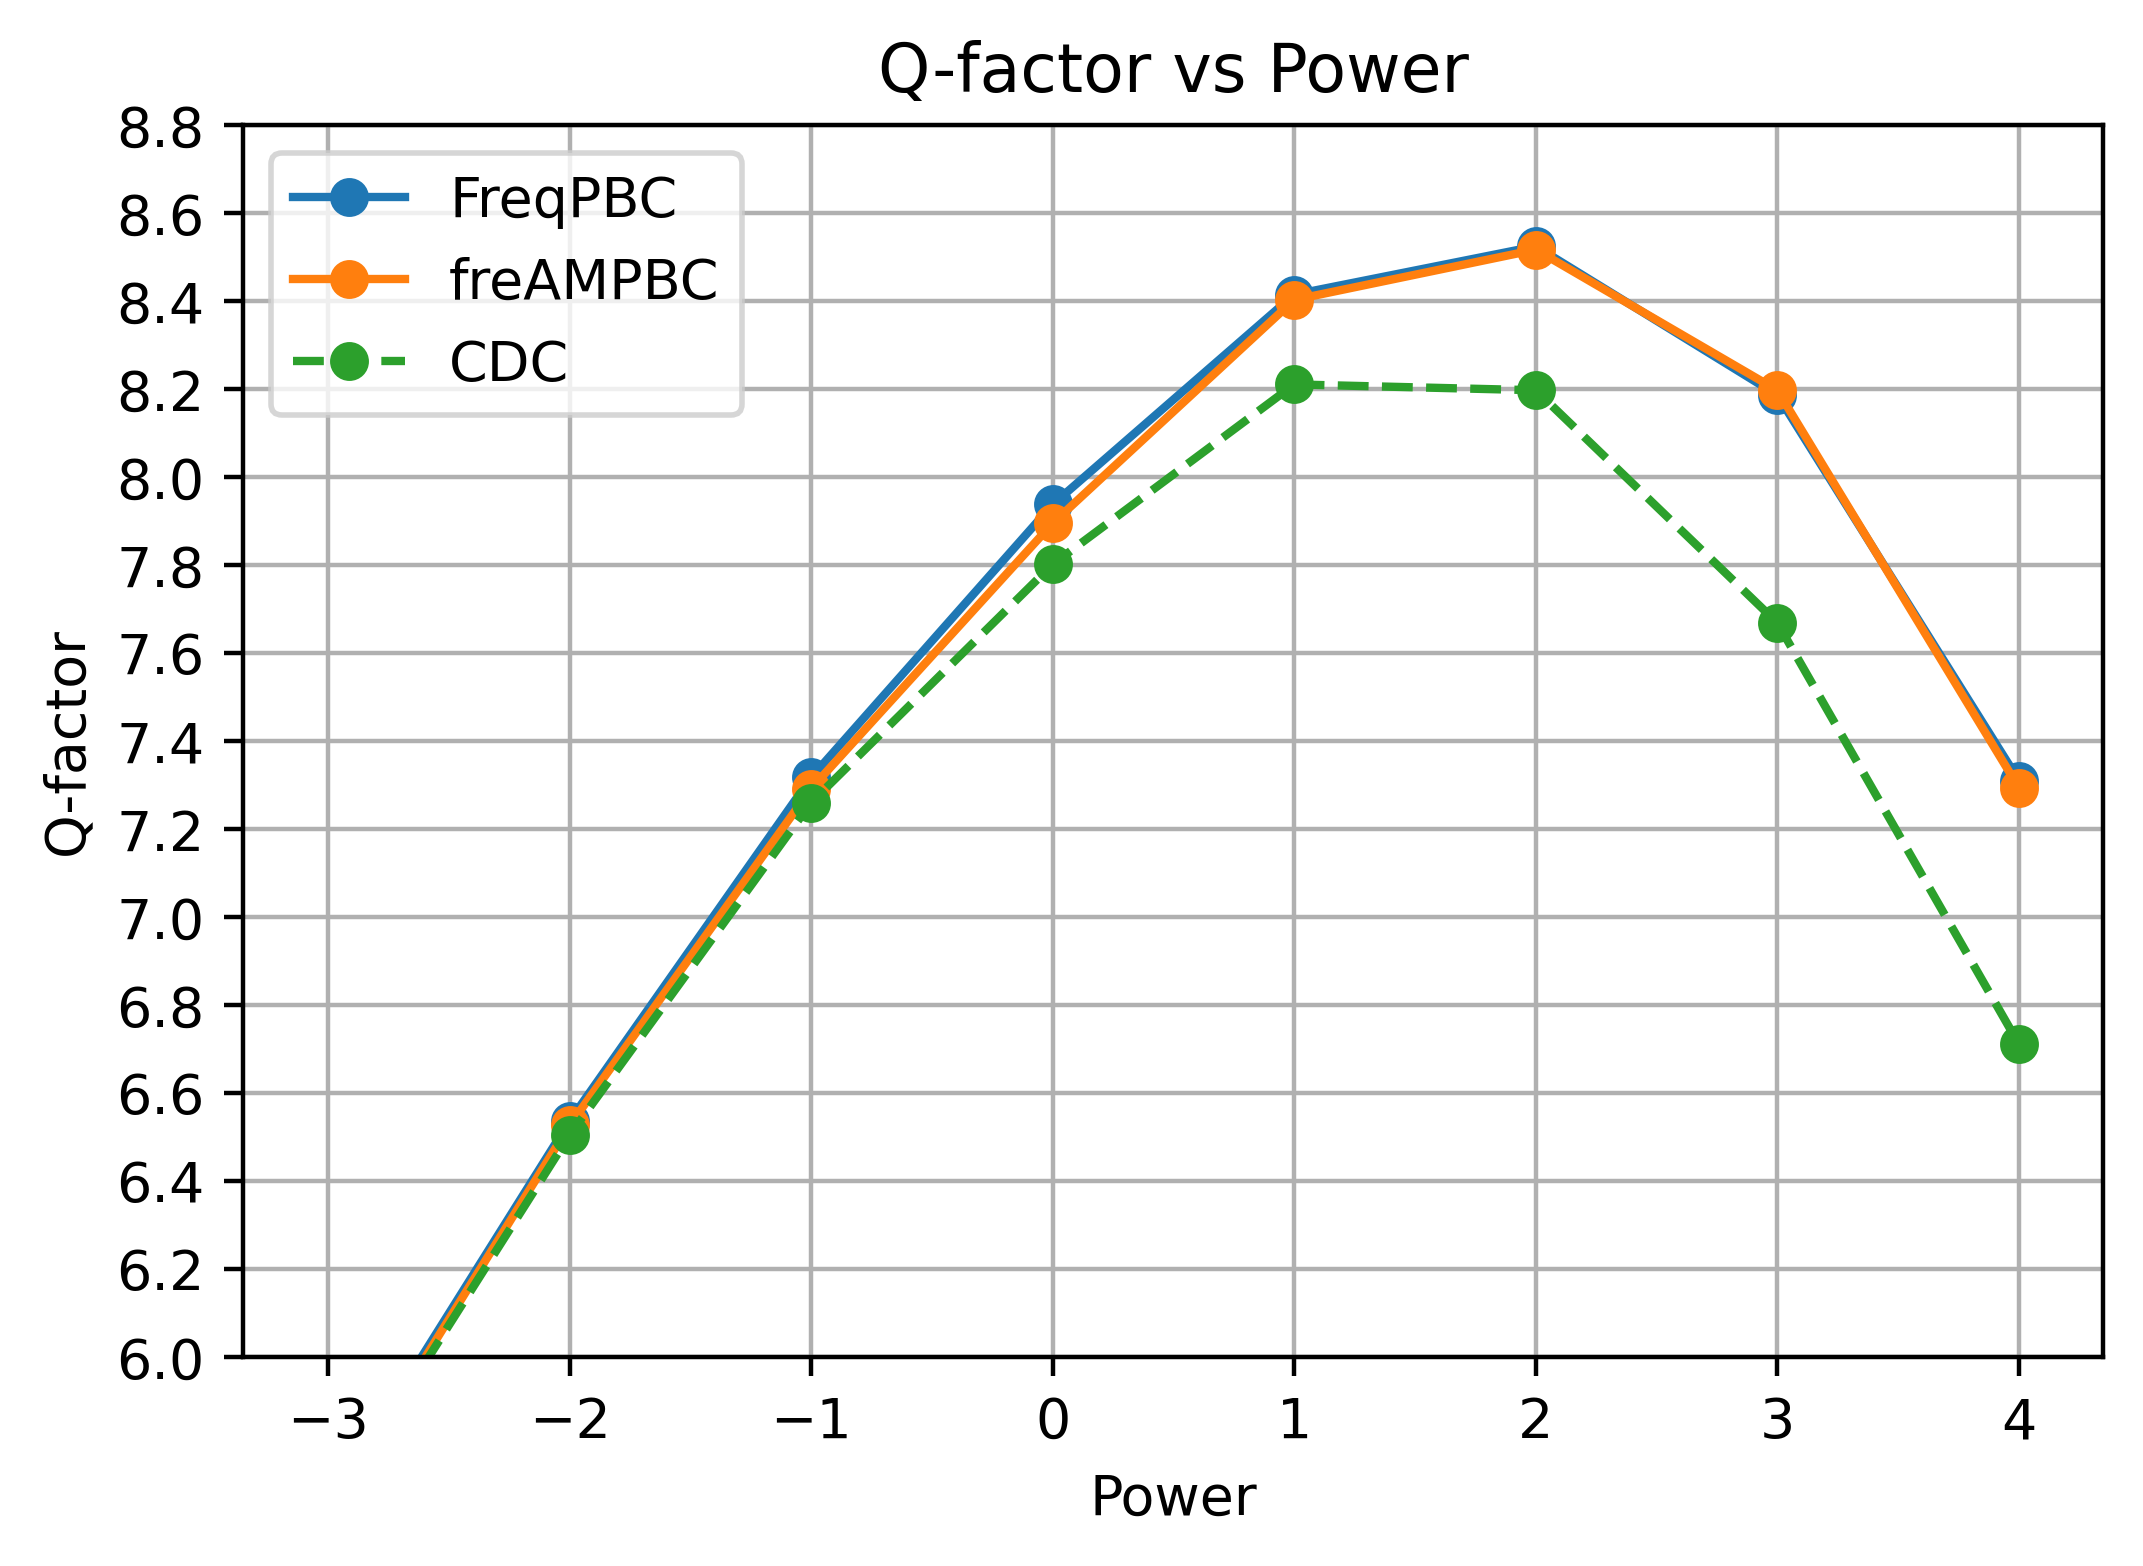

In [55]:
import numpy as np 
import matplotlib.pyplot as plt
from scripts.visualize import load_experiment, load_baseline
import pkufiber as pf

paths = [
        'experiments/80G_3ch_frepbc_M41_rho1_ol40_strides161',
        'experiments/0909_freampbc_v1',
        ]
lab = lambda x: 'FreqPBC' if 'frepbc' in x else 'freAMPBC'

results = {path: load_experiment(path) for path in paths}
labels = {path: lab(path) for path in paths}


plt.figure(dpi=400, figsize=(6, 4))
for key, result in results.items():
    qfactor, power = result['qfactor_power']
    print(f'{key} rmps:', result['model'].rmps())
    plt.plot(power, qfactor, '-o', label=labels[key])
    print(key, 'Best Q afctor: ', np.max(qfactor))

# CDC
cdc, power = load_baseline('configs/dsp/test_eq.yaml', 'CDC')
plt.plot(power, cdc, '--o', label='CDC')


plt.grid()
plt.xlabel('Power')
plt.ylabel('Q-factor')
plt.ylim(6, 8.8)
plt.title('Q-factor vs Power')
plt.yticks(np.arange(6, 8.8, 0.2))
plt.legend(loc='upper left')

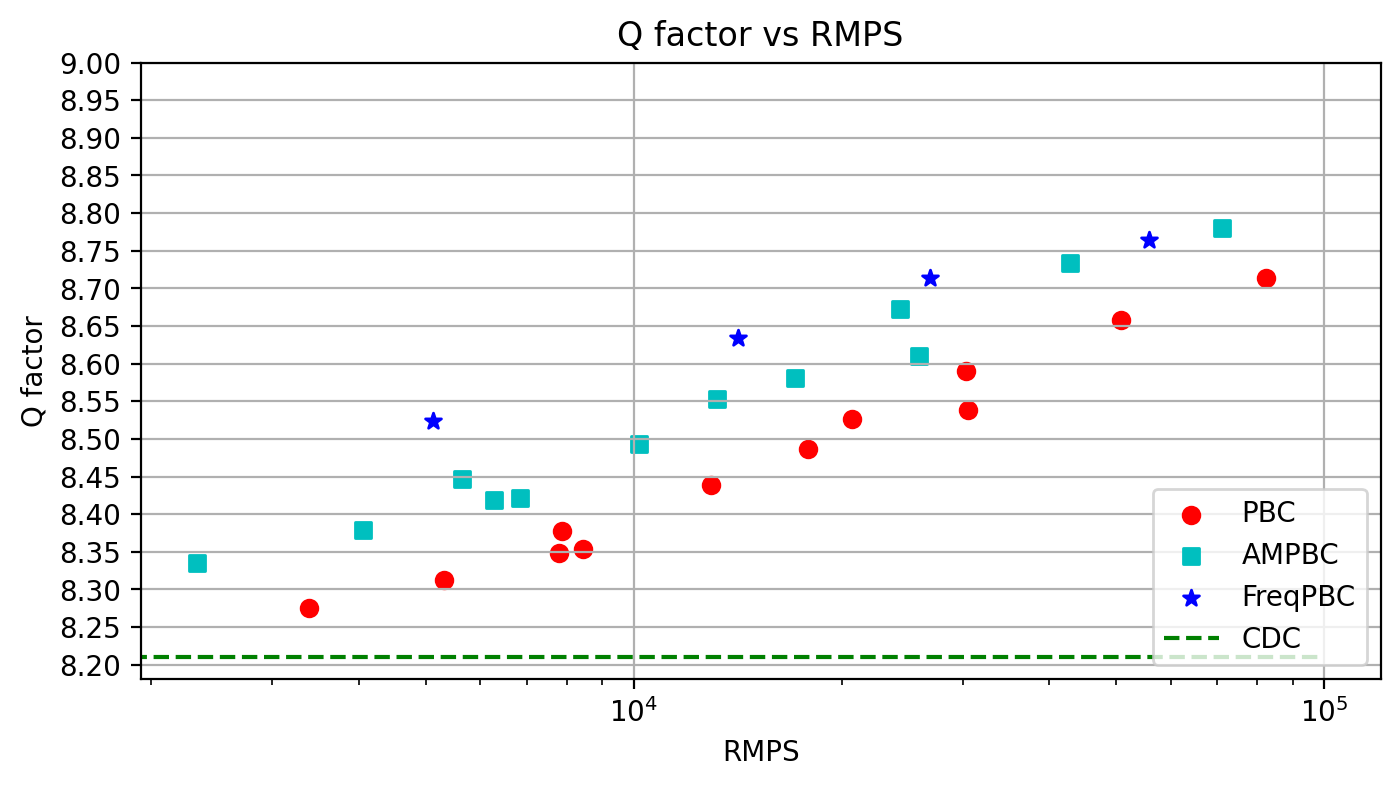

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.visualize import load_experiment, load_baseline
import pkufiber as pf

# load baseline
cdc, power = load_baseline('configs/dsp/test_eq.yaml', 'CDC')

# 路径定义部分
pbc_path = [f'experiments/80G_3ch_pbc_M{M}_rho{rho}' for M in [41, 81, 161] for rho in [1, 2, 4, 8]] 

ampbc_path = [f'experiments/80G_3ch_ampbcstep_M{M}_rho{rho}' for M in [41, 81, 161] for rho in [1, 2, 4, 8]] + [
    'experiments/80G_3ch_ampbc_M401_rho1_v1',
    'experiments/80G_3ch_ampbc_M401_rho0.5_v1',
]
frepbc_path = [
    'experiments/80G_3ch_frepbc_M41_rho1_ol40_strides161',
    'experiments/80G_3ch_frepbc_M201_ol200_rho1_strides201',
    'experiments/80G_3ch_frepbc_M81_rho1_ol80_strides161',
    'experiments/80G_3ch_frepbc_M161_rho1_ol80_strides321',
]

scatter_params = {
    '_frepbc_': {'color': 'b', 'marker': '*', 'label': 'FreqPBC'},
    '_freampbc_': {'color': 'brown', 'marker': 'h', 'label': 'FreqAMPBC'},
    '_ampbcstep_': {'color': 'c', 'marker': 's', 'label': 'AMPBC'},
    '_pbc_': {'color': 'r', 'marker': 'o', 'label': 'PBC'},
}

paths = pbc_path + ampbc_path + frepbc_path  
results = {path: load_experiment(path) for path in paths}


plt.figure(dpi=200, figsize=(8, 4))
labels_plotted = {key: False for key in scatter_params.keys()}
# 遍历结果并绘制 scatter
for key, res in results.items():
    rmps = res['model'].rmps()
    Qmax = np.max(res['qfactor_power'][0])
    
    if '_freqdbp' in key:
        print(key, rmps, Qmax)
    for k, params in scatter_params.items():
        if k in key:
            # 只为首次绘制该类数据时设置标签
            if not labels_plotted[k]:
                plt.scatter(rmps, Qmax, c=params['color'], marker=params['marker'], label=params['label'])
                labels_plotted[k] = True
            else:
                plt.scatter(rmps, Qmax, c=params['color'], marker=params['marker'])
            break
        
# 绘制 CDC 水平线
plt.plot([0, 1e5], [np.max(cdc), np.max(cdc)], '--', c='g', label='CDC')

# 设置图表属性
plt.xlabel('RMPS')
plt.ylabel('Q factor')
plt.yticks(np.arange(8.2, 9, 0.05))
plt.xscale('log')
plt.legend(loc='lower right')
plt.title('Q factor vs RMPS')
plt.grid()
plt.show()